In [1]:
zip_path = "drive/MyDrive/Dogs-Cats/dogs-vs-cats.zip"
!cp "{zip_path}" .
!unzip -q dogs-vs-cats.zip

In [2]:
!rm dogs-vs-cats.zip

In [3]:
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()

2.8.0


'/device:GPU:0'

In [4]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [5]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [6]:
!unzip -q train.zip
!rm train.zip

In [7]:
!unzip -q test1.zip
!rm test1.zip

In [8]:
filenames = os.listdir("train")
categories = []
for f in filenames:
  category = f.split('.')[0]
  if category == 'dog':
    categories.append(1)
  else:
    categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})      

In [9]:
df.head()

,filename,category
0,dog.9782.jpg,1
1,cat.5732.jpg,0
2,cat.609.jpg,0
3,cat.2753.jpg,0
4,dog.7606.jpg,1


In [10]:
df.tail()

,filename,category
24995,dog.5941.jpg,1
24996,cat.3767.jpg,0
24997,cat.9502.jpg,0
24998,dog.1526.jpg,1
24999,cat.8196.jpg,0


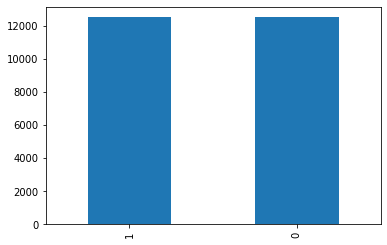

In [11]:
df['category'].value_counts().plot.bar()

Sample Image

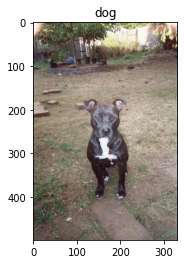

In [12]:
sample = random.choice(filenames)
img = load_img("train/"+sample)
category = df.loc[df['filename'] == sample]['category']
d = {0:"cat", 1:"dog"}
plt.title(d[list(category)[0]])
plt.imshow(img);

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [14]:
model = Sequential()

In [15]:
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(Image_Width, Image_Height, Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [18]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [19]:
earlystop = EarlyStopping(patience=10)

In [32]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [33]:
callbacks = [earlystop, learning_rate_reduction]

In [34]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [35]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

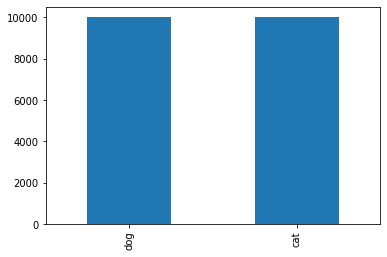

In [36]:
train_df['category'].value_counts().plot.bar()

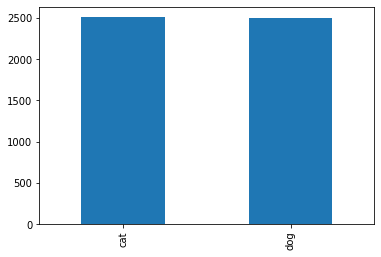

In [37]:
validate_df['category'].value_counts().plot.bar()

In [38]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [39]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [40]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [41]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "train/", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


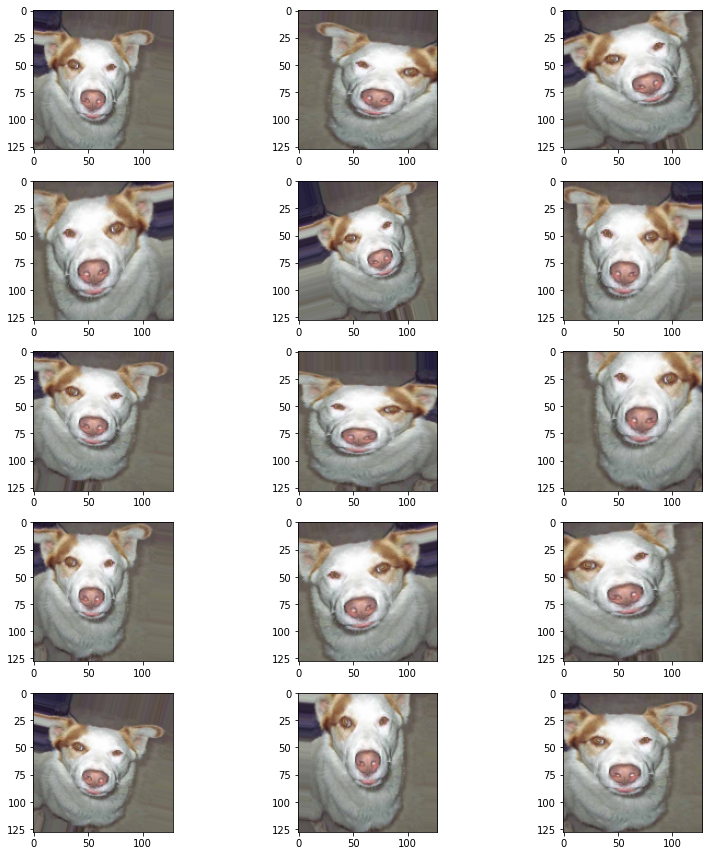

In [42]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [43]:
epochs=50
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50
1333/1333 [==============================] - 170s 127ms/step - loss: 0.5277 - accuracy: 0.7437 - val_loss: 0.8950 - val_accuracy: 0.7061 - lr: 0.0010
Epoch 2/50
1333/1333 [==============================] - 169s 127ms/step - loss: 0.4832 - accuracy: 0.7723 - val_loss: 0.4866 - val_accuracy: 0.7734 - lr: 0.0010
Epoch 3/50
1333/1333 [==============================] - 173s 130ms/step - loss: 0.4618 - accuracy: 0.7898 - val_loss: 0.9271 - val_accuracy: 0.6743 - lr: 0.0010
Epoch 4/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4302 - accuracy: 0.8057
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1333/1333 [==============================] - 174s 130ms/step - loss: 0.4302 - accuracy: 0.8057 - val_loss: 0.4906 - val_accuracy: 0.7704 - lr: 0.0010
Epoch 5/50
1333/1333 [==============================] - 179s 134ms/step - loss: 0.3840 - accuracy: 0.8306 - val_loss: 0.3522 - val_accuracy: 0.8535 - lr: 5.0000e-04
Epoch 6/50
1333/1333 [======

In [45]:
model.save_weights("model.h5")

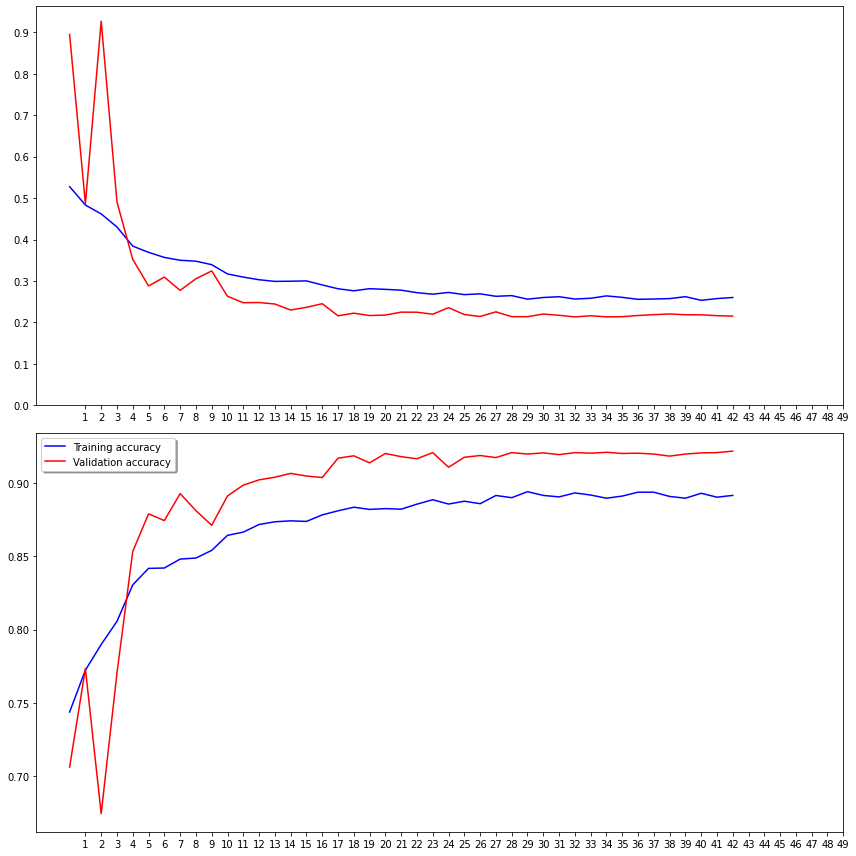

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [49]:
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [50]:
test_df.head()

,filename
0,3780.jpg
1,7332.jpg
2,4794.jpg
3,8447.jpg
4,10225.jpg


In [51]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=Image_Size,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [53]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [54]:
test_df['category'] = np.argmax(predict, axis=-1)

In [55]:
test_df.head()

,filename,category
0,3780.jpg,1
1,7332.jpg,0
2,4794.jpg,1
3,8447.jpg,0
4,10225.jpg,0


In [64]:
test_df.tail()

,filename,category
12495,12257.jpg,0
12496,222.jpg,1
12497,5179.jpg,0
12498,4125.jpg,1
12499,7072.jpg,1


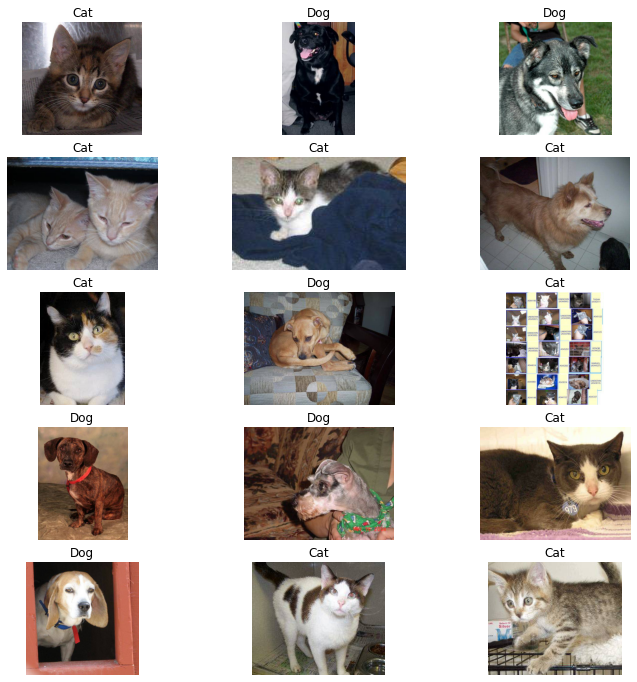

In [71]:
plt.figure(figsize=(12,12))
d = {0: 'Cat', 1: 'Dog'}
for i in range(15):
  plt.subplot(5,3, i+1)
  plt.axis('off')
  index = random.randint(1,12499)
  img = 'test1/' + test_df.iloc[index]['filename']
  category = d[test_df.iloc[index]['category']]
  plt.title(category)
  plt.imshow(load_img(img))             

In [72]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [73]:
test_df.head()

,filename,category
0,3780.jpg,dog
1,7332.jpg,cat
2,4794.jpg,dog
3,8447.jpg,cat
4,10225.jpg,cat


In [74]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

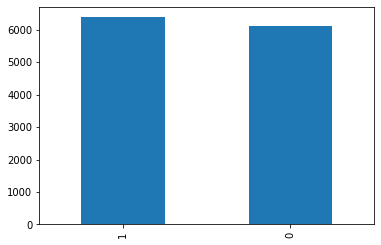

In [75]:
test_df['category'].value_counts().plot.bar()

In [76]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)